In [1]:
%cd ".."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
from sklearn.manifold import TSNE, MDS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
import scipy.spatial as sp
import scipy.stats
import random
import math

from word_embedding.distance_wmd import *
import mantel_test.correlation as mantel_parallel

In [3]:
#Read WMD matrix 
mat_distance_wmd = lecture_fichier_distances_wmd("distances_cbow.7z")
mat_distance_wmd.head()

,0,1,2,3,4,5,6,7,8,9,...,9491,9492,9493,9494,9495,9496,9497,9498,9499,9500
0,0,307,293,386,327,413,329,309,242,632,...,690,370,782,400,277,294,303,327,394,283
1,307,0,81,230,222,370,308,262,131,737,...,735,351,856,419,134,148,160,242,281,115
2,293,81,0,232,229,363,298,239,121,739,...,722,342,853,401,122,145,144,242,260,115
3,386,230,232,0,184,447,350,314,241,758,...,715,451,749,454,188,190,220,176,384,221
4,327,222,229,184,0,397,333,272,218,662,...,680,377,758,390,179,185,221,162,340,194


In [97]:
sample_size = 9501
sample_index = random.sample(range(mat_distance_wmd.shape[0]),sample_size)
mat_distance_wmd_sample = np.copy(mat_distance_wmd.values)
mat_distance_wmd_sample = mat_distance_wmd_sample[np.ix_(sample_index,sample_index)]
mat_distance_wmd_sample

array([[  0, 233, 202, ..., 137, 358, 173],
       [233,   0, 252, ..., 247, 346, 262],
       [202, 252,   0, ..., 212, 377, 260],
       ...,
       [137, 247, 212, ...,   0, 367, 200],
       [358, 346, 377, ..., 367,   0, 364],
       [173, 262, 260, ..., 200, 364,   0]], dtype=uint32)

In [98]:
def x_coord_of_point(D, j):
    return ( D[0,j]**2 + D[0,1]**2 - D[1,j]**2 ) / ( 2*D[0,1] )

def coords_of_point(D, j):
    x = x_coord_of_point(D, j)
    return np.array([x, math.sqrt( D[0,j]**2 - x**2 )])
    
def calculate_positions(D):
    (m, n) = D.shape
    P = np.zeros( (n, 2) )
    tr = ( min(min(D[2,0:2]), min(D[2,3:n])) / 2)**2
    P[1,0] = D[0,1]
    P[2,:] = coords_of_point(D, 2)
    for j in range(3,n):
        P[j,:] = coords_of_point(D, j) 
        if abs( np.dot(P[j,:] - P[2,:], P[j,:] - P[2,:]) - D[2,j]**2 ) > tr:
            P[j,1] = - P[j,1]
    return P 

In [99]:
gram_embedding = calculate_positions(mat_distance_wmd_sample)

<AxesSubplot:>

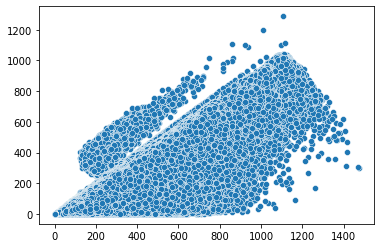

In [100]:
gram_distance = euclidean_distances(gram_embedding)
nb_prop = gram_distance.shape[0]
wmd_triu = mat_distance_wmd_sample[np.triu_indices(nb_prop)]
gram_triu = gram_distance[np.triu_indices(nb_prop)]

sns.scatterplot(x=wmd_triu,y=gram_triu)

In [101]:
np.corrcoef(wmd_triu,gram_triu)

array([[1.        , 0.76798695],
       [0.76798695, 1.        ]])

In [102]:
mds_model = MDS(n_components=300, dissimilarity="precomputed")
mds_embedding = mds_model.fit_transform(mat_distance_wmd_sample)

<AxesSubplot:>

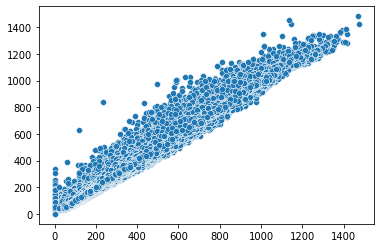

In [103]:
mds_distance = euclidean_distances(mds_embedding)
nb_prop = mds_distance.shape[0]
wmd_triu = mat_distance_wmd_sample[np.triu_indices(nb_prop)]
mds_triu = mds_distance[np.triu_indices(nb_prop)]

sns.scatterplot(x=wmd_triu,y=mds_triu)

In [104]:
np.corrcoef(wmd_triu,mds_triu)

array([[1.        , 0.99608126],
       [0.99608126, 1.        ]])

In [105]:
def MDS_from_gram(D):
    nb_pts = D.shape[0]
    C = np.identity(nb_pts) - (np.ones((nb_pts, 1)) @ np.ones((1, nb_pts))) / nb_pts
    Gram_matrix = (C @ D @ C)*(-0.5)
    
    valeur_propre, vect_prop = np.linalg.eig(Gram_matrix)
    vect_prop = vect_prop[np.argsort(valeur_propre)[::-1]]
    valeur_propre = valeur_propre[np.argsort(valeur_propre)[::-1]] 
    valeur_propre[np.where(valeur_propre <= 10 **(-10))] = 0
    vect_prop[:][np.where(valeur_propre == 0)] = 0

    X_emb = np.diag(np.sqrt(valeur_propre)) @ np.transpose(vect_prop)

    return X_emb

In [106]:
mds_embedding = np.transpose(MDS_from_gram(mat_distance_wmd_sample))

<AxesSubplot:>

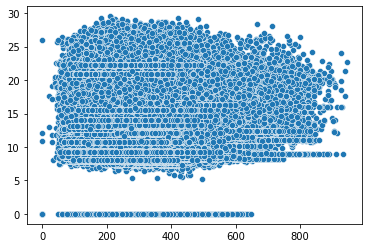

In [ ]:
mds_distance = euclidean_distances(mds_embedding)
nb_prop = mds_distance.shape[0]
wmd_triu = mat_distance_wmd_sample[np.triu_indices(nb_prop)]
mds_triu = mds_distance[np.triu_indices(nb_prop)]

sns.scatterplot(x=wmd_triu,y=mds_triu)